# Data project: *How do price and temperature affect electricity consumption* 

Imports and set magics:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject


## **Introduction** 

In my data project, I want to analyze how electricity consumption is affected by spot prices of electricity and temperature during the period 2020-2023. 

First of all, I want to examine how temperature affect electricity consumption due to the need of heating and cooling when temperature flucturates. Therefore, I use data on households with electric heatingpumps as their main heating source.

Secondly, I want to examine hos spot prices affects households electricity consumption, since the public debate has been focused on electricity savings in relation to Russia's invation in Ukraine.

## **Read and clean data**

I use three data sets; (i) *electricity concumption* from Energy Data Service, (ii) *spotprices of electricity* from Energy Data Service, and finally (iii) *temperature* from DMI API. In the following code, I import and clean the data sets

In [2]:
# (a) Importing data
Price = pd.read_csv("Elspotprices.csv", delimiter = ';')
Consumption_households = pd.read_csv("Consumption.csv", delimiter = ';')
Temperature = pd.read_csv('Temp.csv', delimiter = ';')


# (b) Redefining the puncturation in price data set
Prices = Price['SpotPriceDKK'].values
puncturation = [i.replace(',', '.') for i in Prices]
SpotPrice = list(map(float, puncturation))
Price = Price.reset_index(drop=True)
Price  = pd.concat([Price, pd.DataFrame(puncturation, columns=['SpotPrice'])], axis=1)
Price = Price.drop(columns = ['SpotPriceDKK']) 
Price['SpotPrice'] = Price['SpotPrice'].astype(float)
Price['SpotPrice'] = Price['SpotPrice'].round(1) 


# (e) Defining the temperature variable as a flot type
Temperature['Temperature'] = Temperature['Temperature'].astype(float)


# (d) Visualizing data
Price.head(10)

,HourDK,SpotPrice
0,01-01-2020 00:00,249.6
1,01-01-2020 01:00,237.3
2,01-01-2020 02:00,235.8
3,01-01-2020 03:00,233.7
4,01-01-2020 04:00,230.4
5,01-01-2020 05:00,225.1
6,01-01-2020 06:00,225.4
7,01-01-2020 07:00,224.1
8,01-01-2020 08:00,228.8
9,01-01-2020 09:00,228.5


I will only analyze the electricity consumption of **households with electric heatpumps**, since they are directly influenced by the spot price of electricity in contrast to households with district heating or natural gas. 

In the following, I visulalize *Consumption Households*.

In [3]:
# (b) Visualizing consumption data 
Consumption_households.head(10)

,HourDK,TotalCon
0,01-01-2020 00:00,71745
1,01-01-2020 01:00,69178
2,01-01-2020 02:00,66507
3,01-01-2020 03:00,63600
4,01-01-2020 04:00,61401
5,01-01-2020 05:00,60767
6,01-01-2020 06:00,61615
7,01-01-2020 07:00,63114
8,01-01-2020 08:00,67394
9,01-01-2020 09:00,73553


Now, I redefine the time variable *HourDK* to a date time variable for all data sets, so I can merge the data sets by this variable

In [4]:
# (a) consumption data set
Consumption_households['HourDK'] = pd.to_datetime(Consumption_households['HourDK'])


# (b) price data set
Price['HourDK']=pd.to_datetime(Price['HourDK'])


# (b) Temperature data set
Temperature['HourDK']=pd.to_datetime(Temperature['HourDK'])

## **Merge data sets**

The three data sets are merged by the time variable *HourDK*. Since the total consumption only consist of *Households with a heatpump* (122), I drop the variable *ConsumerType_DE35*

In [5]:
# (a) Merging the two data sets
PC = pd.merge(Price, Consumption_households, on='HourDK', how='outer')
PC = pd.merge(PC, Temperature, on='HourDK', how='outer')


# (b) Visualizing data
PC.head(10)

,HourDK,SpotPrice,TotalCon,Temperature
0,2020-01-01 00:00:00,249.6,71745.0,4.7
1,2020-01-01 01:00:00,237.3,69178.0,4.9
2,2020-01-01 02:00:00,235.8,66507.0,5.1
3,2020-01-01 03:00:00,233.7,63600.0,5.1
4,2020-01-01 04:00:00,230.4,61401.0,5.2
5,2020-01-01 05:00:00,225.1,60767.0,5.3
6,2020-01-01 06:00:00,225.4,61615.0,5.3
7,2020-01-01 07:00:00,224.1,63114.0,5.0
8,2020-01-01 08:00:00,228.8,67394.0,5.0
9,2020-01-01 09:00:00,228.5,73553.0,5.4


## **Summarization**

To get an overview of the merged data set, the data set is summarized in the following:

In [6]:
# (i) running a describtion code with only one decimal
pd.options.display.float_format = '{:.1f}'.format
PC.describe()

,SpotPrice,TotalCon,Temperature
count,27738.0,27738.0,27739.0
mean,824.6,52887.9,8.7
std,893.3,23584.2,6.5
min,-437.5,16288.0,-17.4
25%,223.4,32074.0,4.0
50%,505.9,50258.0,8.2
75%,1125.6,70273.5,13.4
max,6478.2,147900.0,34.4


The table above illustrates, that the spot price of electricity has a negative minimum value, which indicates an oversupply of electricity during the analyzed time period.

The temperature has flucturated heavily between -17.4 and 34.4 degrees

And finally, the table illustraties that the *mean* and the *50 pct. quantile* of consumption is relatively similar, which indicates that the distribution is neither right nor left skewed. 

## **Analysis**

In the analysis, I will examine how temperature, spot price of electricity and electricity consumption are correlated.

### Temperature and electricity consumption

First of all, I illustrate the mean monthly temperature in **Figure 1**

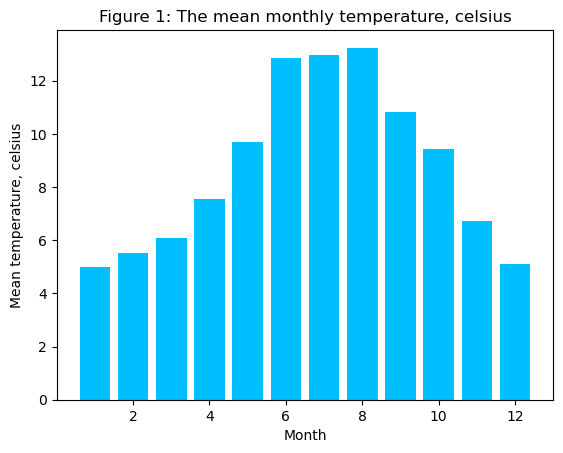

In [7]:
#(a) Defining a new variable called 'month'
PC['month'] = PC['HourDK'].dt.month


# (b) Calculating the mean temperature of each month
monthly_mean_temperature = PC.groupby('month')['Temperature'].mean()


# (c) creating and adjusting the plot
plt.bar(monthly_mean_temperature.index, monthly_mean_temperature.values, color='deepskyblue')
plt.xlabel('Month')
plt.ylabel('Mean temperature, celsius')
plt.title('Figure 1: The mean monthly temperature, celsius')
plt.show()

As expected, the highest mean temperatures are observed during summer months, while the temperature is at the lowest from december to february.

As explained in the introduction, I want to analyze, how temperature affects consumption. My hypothesis is, that *temperature is negative correlated with electricity consumption for households with electric heatpumps due to extra need of heating in low temperatures*

Therefore, I estimate the mean monthly consumption for households and compare it to the monthly temperature:

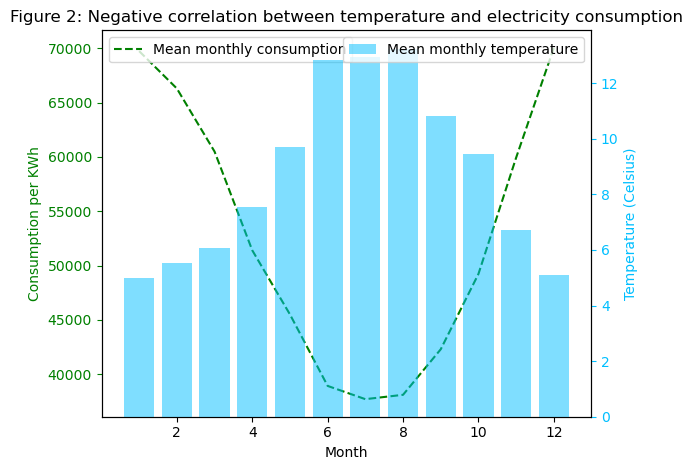

In [8]:
# (a) Extimating the mean monthly consumption
monthly_mean_consumption = PC.groupby('month')['TotalCon'].mean()


# (b) Defining data
x = monthly_mean_consumption.index
y1 = monthly_mean_consumption.values
y2 = monthly_mean_temperature.values


# (c) Creating the merged figure (two y-axis)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


# (d) Adjusting the first y-axis (mean monthly consumption per KWh)
ax1.plot(x, y1, 'green', linestyle='--', label='Mean monthly consumption')
ax1.set_xlabel('Month')
ax1.set_ylabel('Consumption per KWh', color='green')
ax1.tick_params('y', colors='green')


# (e) Adjusting the second y-axis (mean monthly temperature, celsius)
ax2.bar(x, y2, color='deepskyblue', alpha=0.5, label='Mean monthly temperature')
ax2.set_ylabel('Temperature (Celsius)', color='deepskyblue')
ax2.tick_params('y', colors='deepskyblue')


# (f) adjusting the figure
plt.title('Figure 2: Negative correlation between temperature and electricity consumption')
plt.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

**Figure 2** illustrates that electricity consumption and temperature is negatively correlated as expected. During the summer months, the electricity consumption is at the lowest point, while the temperature is highest. This indicates, that the households do not use electricity for heating during summer

### Spot price and electricity consumption

Secondly, I want to exmine how the daily consumption of electricity is correlated with the spot price of electricity. 

In **Figure 3**, the mean daily consumption of electriciy is illustrated:

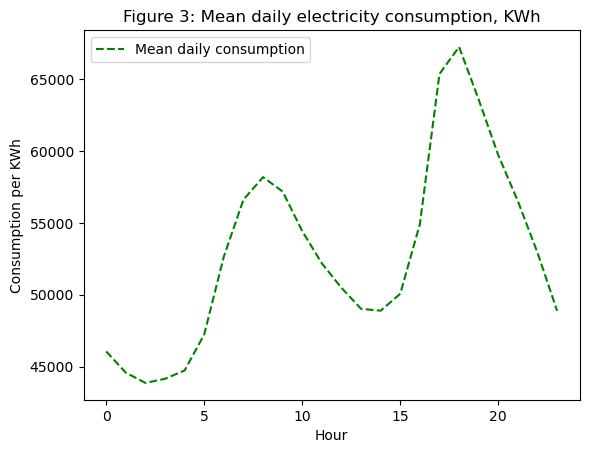

In [9]:
#(a) Defining a new variable called 'hour'
PC['hour'] = PC['HourDK'].dt.hour


# (b) Estimating mean hourly consumption for the period
hourly_mean_consumption = PC.groupby('hour')['TotalCon'].mean()


# (c) Creating a figure
fig, ax = plt.subplots()
hourly_mean_consumption.plot(ax=ax, color='green', linestyle = '--', label='Mean daily consumption')


# (d) Adjusting the graph
ax.set_xlabel('Hour')
ax.set_ylabel('Consumption per KWh')
ax.set_title('Figure 3: Mean daily electricity consumption, KWh')
ax.legend(loc='upper left')
plt.show()

**Figure 3** illustrates two very clear consumption peaks - one peak around 8 am, which is presumably caused by morning routines in the households. The other consumption peak is around 7 pm, which is presumably caused by dinner preparing and other household duties like laundry and dishwashing.

In **Figure 4**, I include the mean daily spot price of electricity, since my hypothesis is that *the spot price of electricity and electricity consumption are interdependent, cf. standard economic theory of market price determination*.

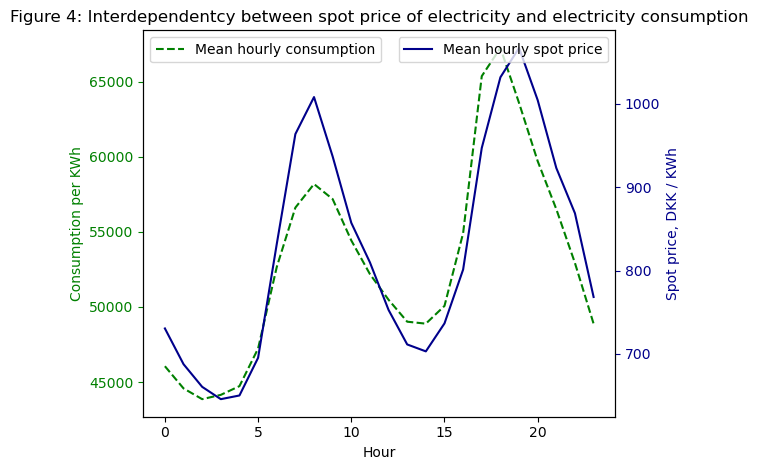

In [10]:
# (a) Calculating the mean hourly spot price
mean_hourly_SP = PC.groupby('hour')['SpotPrice'].mean()


# (b) Defining data
x = hourly_mean_consumption.index
y1 = hourly_mean_consumption.values
y2 = mean_hourly_SP.values


# (c) Creating the merged figure (two y-axis)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


# (d) Adjusting the first y-axis (mean monthly consumption per KWh)
ax1.plot(x, y1, 'green', linestyle='--', label='Mean hourly consumption')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Consumption per KWh', color='green')
ax1.tick_params('y', colors='green')


# (e) Adjusting the second y-axis (mean monthly temperature, celsius)
ax2.plot(x, y2, color='darkblue', label='Mean hourly spot price')
ax2.set_ylabel('Spot price, DKK / KWh', color='darkblue')
ax2.tick_params('y', colors='darkblue')


# (f) adjusting the figure
plt.title('Figure 4: Interdependentcy between spot price of electricity and electricity consumption')
plt.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

From **Figure 4**, it is clear that electricity consumption and spot price of electricity are strongly correlated. 

Do to the price setting structure of the electricity market, the spot price of electricity is to some extent determined by the demand. Opposite, the spot prices can also influence the demand, which we have seen in 2022 (after Russia's invation of Ukraine), where public institution were only allowed to heat untill 19 degrees celsius. 

However, the spot price of electricity is also affected by the energy source, since the energy demand is always covered by the cheapest energy sources availible. If the cheapest energy source is not sufficient to cover all the demand, the second cheapest energy source is used and so on. The spot price of electricity is determined by the most expensive energy source that is used.

To decide the direction of causality between electricity consumption and spot price of electricity, several tests must be done however, this paper will only focus on the correlations.

### Temperature and spot price of electricity

Finally, I examine the correlation between temperature and spot price of electricity. The potential correlation is caused by several factors:

* Temperature might be correlated with solar power plants production. And since solar power plants are cheaper than fossil fuels, the production of electricity from soler power plants decreases the spot price of electricity. Thereby, the temperature might be negatively correlated with the spot price of electricity.

* Higher temperatures decreases the electricity consumption, cf. **Figure 2**. When the electricity consumption is low, renewable energy sources might be sufficient to cover the demand, and so the spot price of electricity decreases due to the price setting mechanism on the electricity market.

Therefore, my hypothesis is that *spot price of electricity and temperature are negatively correlated*

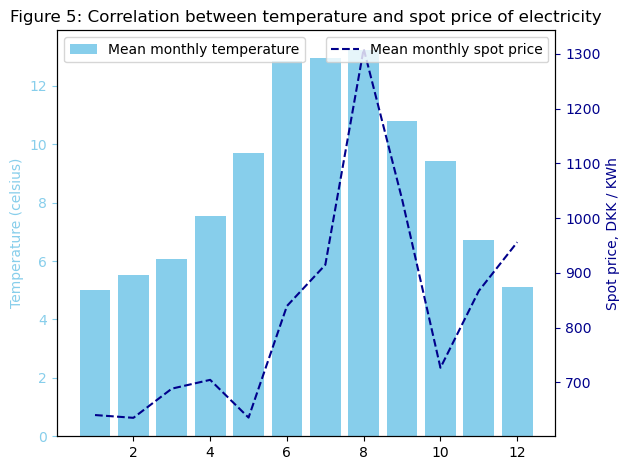

In [11]:
# (a) Calculating the mean monthly temperature
mean_monthly_SP = PC.groupby('month')['SpotPrice'].mean()


# (b) Defining data
x = mean_monthly_SP.index
y1 = mean_monthly_SP.values
y2 = monthly_mean_temperature.values


# (c) Creating the merged figure (two y-axis)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


# (d) Adjusting the first y-axis (mean monthly temperature, celsius)
ax1.bar(x, y2, color='skyblue', label='Mean monthly temperature')
ax1.set_ylabel('Temperature (celsius)', color='skyblue')
ax1.tick_params('y', colors='skyblue')


# (e) Adjusting the second y-axis (mean monthly spot price)
ax2.plot(x, y1, 'darkblue', linestyle='--', label='Mean monthly spot price')
ax2.set_xlabel('Month')
ax2.set_ylabel('Spot price, DKK / KWh', color='darkblue')
ax2.tick_params('y', colors='darkblue')


# (f) Adjust the figure
plt.title('Figure 5: Correlation between temperature and spot price of electricity')
plt.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

Based on **Figure 5**, my hypothesis is completely false, since the figure illustrates a *positive* correlation between spot price and temperature. This might be caused by Russia's invation in Ukraine in 2022, where the spot price of electricity increased dramatically in august, semptember, and october. Therefore, I will estimate the same figure as above but without 2022.

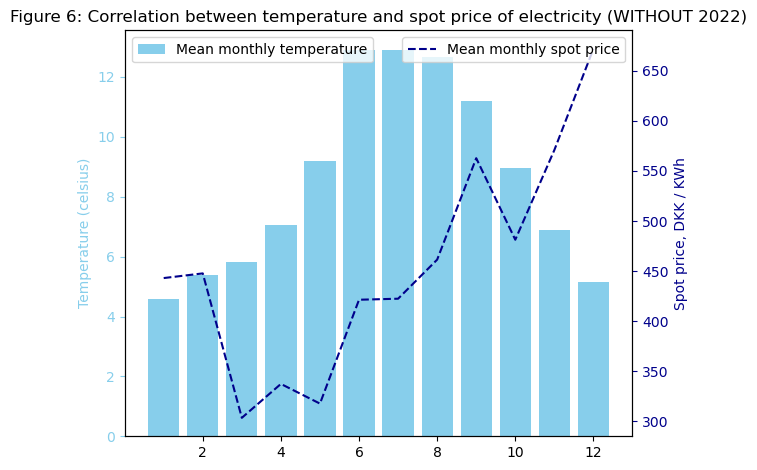

In [12]:
#(a) Defining a new variable called 'year'
PC['year'] = PC['HourDK'].dt.year


# (b) Removing data from 2022
PC_withoutwar = PC[PC['year'] != 2022]


# (c) Calculating the mean monthly temperature and spot price
mean_monthly_SP_withoutwar = PC_withoutwar.groupby('month')['SpotPrice'].mean()
mean_monthly_temperature_withoutwar = PC_withoutwar.groupby('month')['Temperature'].mean()


# (d) Defining data
x = mean_monthly_SP_withoutwar.index
y1 = mean_monthly_SP_withoutwar.values
y2 = mean_monthly_temperature_withoutwar.values


# (e) Creating the merged figure (two y-axis)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()


# (f) Adjusting the first y-axis (mean monthly temperature, celsius)
ax1.bar(x, y2, color='skyblue', label='Mean monthly temperature')
ax1.set_ylabel('Temperature (celsius)', color='skyblue')
ax1.tick_params('y', colors='skyblue')


# (g) Adjusting the second y-axis (mean monthly spot price)
ax2.plot(x, y1, 'darkblue', linestyle='--', label='Mean monthly spot price')
ax2.set_xlabel('Month')
ax2.set_ylabel('Spot price, DKK / KWh', color='darkblue')
ax2.tick_params('y', colors='darkblue')


# (h) adjusting the figure
plt.title('Figure 6: Correlation between temperature and spot price of electricity (WITHOUT 2022)')
plt.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

**Figure 6** illustrates a rather different picture, where the spot price to some extent is negatively correlated with the temperature. This might be casued by:

* Lower electricity consumption for heating during summer and spring months which lowers the spot price, cf. price setting mechanisms at the electricity market

* Positive correlation between temperature and electricity production from solar power plant, which decreases the spot prices of electricity


However, the correlation is weak, which indicates that a lot of other parameters affect the spot prices of electricity

## **Conclusion**

In my data project, I find the following correlations:

* First of all, a negatively correlation between mean monthly temperature and electricity consumption, which is explained by lower need for heating during the summer months

* Secondly, a strong positive correlation between mean daily spot price of electricity and electricity consumption for households with electric heatpumps. This indicates that consumption affects spot price due to the price setting mechanisms of electricity

* Finally, the mean montly spot price is strongly affected by 2022, where the electricity prices increased dramatically due to Russia's invation in Ukraine. When removing 2022 from the data set, the correlation between spot price of electricity and temperature becomes partly negative however, the correlation is rather weak.